In [7]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
import torch

In [8]:
def plot_fused_decision_boundary(x, y, objective, new_candidates = None) -> None:
    x_min, x_max = x[:, 0].min() - 50, x[:, 0].max() + 50
    y_min, y_max = x[:, 1].min() - 0.15, x[:, 1].max() + 0.05
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    mask = objective >= 8.5

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, z, alpha=0.3, cmap='coolwarm_r')
    plt.scatter(x[:, 0], x[:, 1], c=mask, edgecolor='k', cmap = ListedColormap(['lightgray', 'green']))
    if new_candidates is not None:
        plt.scatter(new_candidates[:, 0], new_candidates[:, 1], c='blue', marker='x', s=100, label='New Candidates')
    plt.xlabel('Power')
    plt.ylabel('Hatch Distance')
    plt.title('Fused Classification Decision Boundary (Random Forest)')
    red_patch = patches.Patch(color=plt.cm.coolwarm_r(1.0), label='Fused')  # red area
    blue_patch = patches.Patch(color=plt.cm.coolwarm_r(0.0), label='Not Fused')  # blue area
    green_patch = patches.Patch(facecolor='green', edgecolor='k', label='Fused (objective ≥ 8.5)')
    gray_patch = patches.Patch(facecolor='lightgray', edgecolor='k', label='Not Fused (objective < 8.5)')
    plt.legend(handles=[red_patch, blue_patch, green_patch, gray_patch], loc='lower right')
    plt.grid(True)
    plt.show()



=== report ===
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92         6
         1.0       1.00      0.83      0.91         6

    accuracy                           0.92        12
   macro avg       0.93      0.92      0.92        12
weighted avg       0.93      0.92      0.92        12



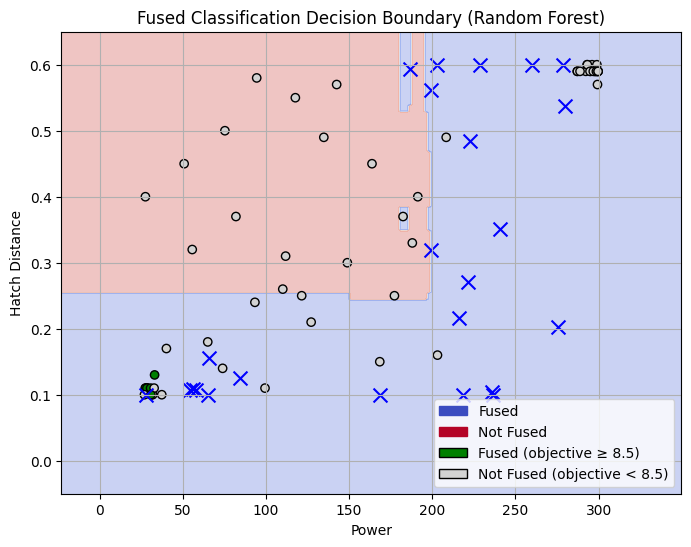

In [9]:
# ---------- 0. Initialization  ---------- #
# matplotlib.use("TkAgg")  # Fix compatibility issues between matplotlib and botorch
# torch.manual_seed(42)   # Fixed random seed to reproduce results (Default: negative)

# 0.1 Set constance and Hyper parameters
# Set parameters limit（Power, Hatch_distance）
bounds = torch.tensor([
    [25, 0.1, 25],  # Lower bounds
    [300, 0.6, 300]  # Upper bounds
], dtype=torch.double)

# ---------- 1. Initial Samples  ---------- #
# Initial Samples from old tasks
df = pd.read_csv("RF_batch_bo_summary.csv")
X = torch.tensor(df[["power", "hatch_distance", "outline_power"]].values, dtype=torch.double)
Y = torch.tensor(df[["label_visibility", "surface_uniformity"]].values, dtype=torch.double)
Fused_Label = torch.tensor(df[["fused"]].values, dtype=torch.double).squeeze()
Objective = torch.tensor(df[["objective"]].values, dtype=torch.double).squeeze()
df = pd.read_csv("Candidates.csv")
# X_candidates = torch.tensor(df[["power", "hatch_distance", "outline_power"]].values, dtype=torch.double)
X_candidates = torch.tensor([[5.6012e+01, 1.0821e-01, 2.5000e+01],
        [2.3630e+02, 1.0000e-01, 5.9699e+01],
        [2.7565e+02, 2.0285e-01, 6.7474e+01],
        [2.4076e+02, 3.5139e-01, 1.9437e+02],
        [2.1578e+02, 2.1565e-01, 5.3454e+01],
        [6.5692e+01, 1.5637e-01, 2.3815e+02],
        [2.2266e+02, 4.8472e-01, 8.2763e+01],
        [2.0306e+02, 6.0000e-01, 2.2618e+02],
        [2.2894e+02, 6.0000e-01, 4.9782e+01],
        [2.7992e+02, 5.3777e-01, 8.5677e+01],
        [5.4347e+01, 1.0783e-01, 2.5000e+01],
        [1.6845e+02, 1.0000e-01, 2.4196e+02],
        [8.4199e+01, 1.2604e-01, 2.5719e+02],
        [2.2150e+02, 2.7031e-01, 1.2939e+02],
        [2.7872e+02, 6.0000e-01, 2.9127e+02],
        [2.3565e+02, 1.0483e-01, 5.1416e+01],
        [1.9900e+02, 3.1965e-01, 4.1310e+01],
        [6.5433e+01, 1.0000e-01, 2.8154e+02],
        [1.9903e+02, 5.6233e-01, 1.2649e+02],
        [2.5988e+02, 6.0000e-01, 4.6353e+01],
        [2.7796e+01, 1.0000e-01, 1.6546e+02],
        [5.8072e+01, 1.0776e-01, 2.5000e+01],
        [1.8633e+02, 5.9349e-01, 2.7167e+02],
        [2.1858e+02, 1.0000e-01, 1.9404e+02]], dtype=torch.float64)
# Y = Y[:, 1:]  # only need the last three columns
# print(X.shape, Y.shape)

# ---------- 2. Random Forest Classifier  ---------- #
X_RF = X[:,0:2]
# 2.1 Split test set (test_size: Test set ratio)
X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(X_RF, Fused_Label, test_size=0.2, random_state=37)

# 2.2 Train (n_estimators: # of random trees, the higher, the better)
clf = RandomForestClassifier(n_estimators=5000, random_state=96)
clf.fit(X_RF_train, y_RF_train)

# 2.3 Evaluation
#   model \ target |    positive     |    negative
# ----------------------------------------------------
#      true        |  true_positive  | false_positive
# ----------------------------------------------------
#      false       | false_negative  | true_negative
# ----------------------------------------------------

# precision = true_positive/(true_positive+false_positive)
# recall = true_positive/(true_positive+false_negative)
# F1 Score = 2 * (precision * recall) / (precision + recall)
y_pred = clf.predict(X_RF_test)
print("=== report ===")
print(classification_report(y_RF_test, y_pred))

# 2.4. visualization
plot_fused_decision_boundary(X_RF, Fused_Label, Objective, X_candidates)